In [1]:
from glob import glob
path_to_subtitles = sorted(glob("./subtitles/*.ass"))

In [2]:
path_to_subtitles[:10]

['./subtitles/001_LEG_English.ass',
 './subtitles/002_LEG_English.ass',
 './subtitles/003_LEG_English.ass',
 './subtitles/004_LEG_English.ass',
 './subtitles/005_LEG_English.ass',
 './subtitles/006_LEG_English.ass',
 './subtitles/007_LEG_English.ass',
 './subtitles/008_LEG_English.ass',
 './subtitles/009_LEG_English.ass',
 './subtitles/010_LEG_English.ass']

In [3]:
scripts=[]
episode_number=[]
for path in path_to_subtitles:
    with open(path,'r') as file:
        lines = file.readlines()
        lines = lines[27:]

        rows = [",".join(line.split(",")[9:]) for line in lines]

    rows = [line.replace("\\N"," ") for line in rows]
    script = " ".join(rows)

    episode = int(path.split('_')[0].split('/')[2].strip())
    scripts.append(script)
    episode_number.append(episode)    
    

 

In [4]:
import pandas as pd
df = pd.DataFrame.from_dict({'episode':episode_number,'script':scripts})


In [5]:
df.head()

,episode,script
0,1,"A long time ago, a powerful demon fox appeared..."
1,2,"C'mon!\n Running like a fugitive,\n Being chas..."
2,3,"C'mon!\n Running like a fugitive,\n Being chas..."
3,4,"C'mon!\n Running like a fugitive,\n Being chas..."
4,5,"C'mon!\n Running like a fugitive,\n Being chas..."


In [6]:
import spacy

In [7]:
import en_core_web_sm
nlp = en_core_web_sm.load()

/home/suraj/anaconda3/envs/naruto/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
doc = nlp("Sasuke went to konoha")

In [9]:
for ent in doc.ents:
    print(ent.text,ent.label_)

Sasuke PERSON
konoha GPE


In [10]:
import nltk
# nltk.download('punkt')
from nltk import sent_tokenize

In [12]:
def get_ners(script):
    script_sentences = sent_tokenize(script)

    ner_output = []

    for sentence in script_sentences:
        doc = nlp(sentence)
        ners = set()    
        for ent in doc.ents:
            if ent.label_ == 'PERSON':
                full_name = ent.text
                first_name = full_name.split(' ')[0]
                ners.add(first_name)
        ner_output.append(list(ners))
    return ner_output                    


In [13]:
df['ners'] = df['script'].apply(get_ners)

In [14]:
window = 10
entity_relationship = []

for row in df['ners']:
    previous_entities_in_window = []

    for sentence in row:
        previous_entities_in_window.append(sentence)
        previous_entities_in_window = previous_entities_in_window[-10:]

        previous_entities_flattend = sum(previous_entities_in_window,[])

        for entity in sentence:
            for entity_in_window in previous_entities_flattend:
                if entity!= entity_in_window:
                    entity_rel = sorted([entity,entity_in_window])
                    entity_relationship.append(entity_rel)


In [15]:
relationship_df = pd.DataFrame({'value':entity_relationship})
relationship_df['source'] = relationship_df['value'].apply(lambda x: x[0])
relationship_df['target'] = relationship_df['value'].apply(lambda x: x[1])

In [16]:
relationship_df = relationship_df.groupby(['source','target']).count().reset_index()
relationship_df = relationship_df.sort_values('value',ascending=False)
relationship_df.head()

,source,target,value
1528,Sakura,Sasuke,170
1114,Kakashi,Sasuke,131
740,Guy,Lee,93
551,Gaara,Lee,69
560,Gaara,Sasuke,67


In [17]:
relationship_df = relationship_df.head(200)

In [18]:
import networkx as nx

G = nx.from_pandas_edgelist(relationship_df,
                            source="source",
                            target="target",
                            edge_attr="value",
                            create_using=nx.Graph())

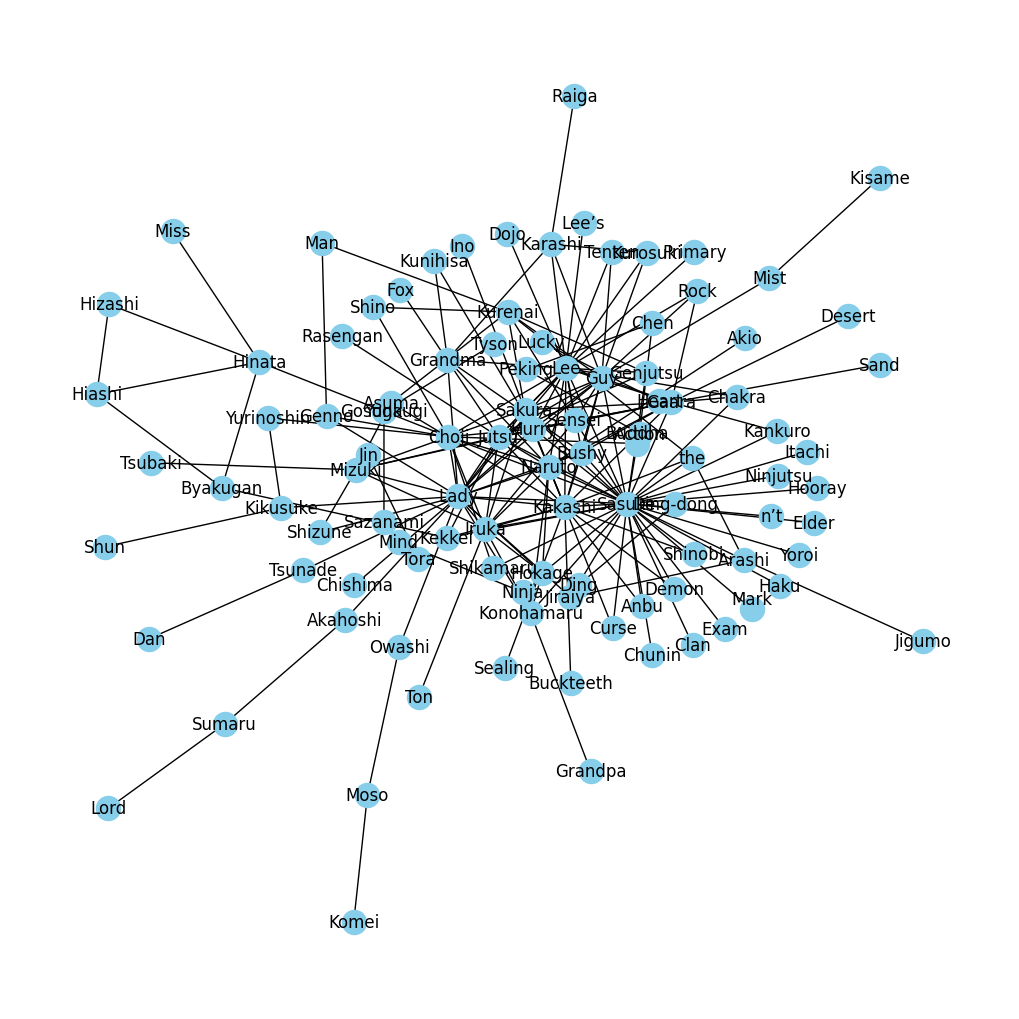

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
pos = nx.kamada_kawai_layout(G)
nx.draw(G,with_labels = True, node_color = "skyblue", edge_cmap = plt.cm.Blues, pos = pos)
plt.show()

In [20]:
from pyvis.network import Network
net = Network(notebook = True, width = "1000px", height = "700px", bgcolor = "#222222", font_color = "white")
node_degree = dict(G.degree)

nx.set_node_attributes(G, node_degree,'size')

net.from_nx(G)
net.show('naruto.html')

naruto.html
